In [148]:
!pip install tensorflow numpy pandas matplotlib kagglehub

In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import kagglehub

In [150]:
# Завантаження даних
path = kagglehub.dataset_download("mnassrib/jena-climate")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mnassrib/jena-climate/versions/1


In [151]:
# Завантаження та обробка датасету
df = pd.read_csv(os.path.join(path, "jena_climate_2009_2016.csv"))
# Перевірка наявності функції замість DataFrame
print(df)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420546  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420547  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420548  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420549  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420550  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.

In [152]:
# Використання стовпця температури
# Взяття середнього значення за кожні 6 елементів у стовпці температури
temp_data = df['T (degC)'].values
# Обрізання кількості елементів до найближчого кратного 6
trim_size = len(temp_data) - (len(temp_data) % 24)
temp_data = temp_data[:trim_size]
mean_temp_data = np.mean(temp_data.reshape(-1, 24), axis=1).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp_data = scaler.fit_transform(mean_temp_data)

In [153]:
# Підготовка навчальних даних
def create_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [154]:
time_steps = 10  # Кількість часових кроків для навчання
X, y = create_dataset(scaled_temp_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [155]:
# Розділення на навчальні, валідаційні та тестові дані
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [156]:
# Побудова оновленої моделі LSTM
model = Sequential()

# Перший LSTM шар із 100 нейронами, повертає послідовності для наступного шару
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)))

# Другий LSTM шар із 50 нейронами, повертає послідовності для наступного шару
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

# Третій LSTM шар із 50 нейронами, не повертає послідовності
model.add(LSTM(50, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

# Вихідний Dense шар для прогнозування одного значення
model.add(Dense(1))

# Компіляція моделі з функцією втрат MSE та метрикою MAE (Mean Absolute Error)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [157]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                       │ (None, 10, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 10, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,251 (356.45 KB)

 Trainable params: 91,251 (356.45 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# Навчання моделі
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=16, verbose=2, callbacks=[early_stopping, tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}: Training MSE={logs['loss']:.4f}, Validation MSE={logs['val_loss']:.4f}"))])


Epoch 1/40
Epoch 1: Training MSE=0.0122, Validation MSE=0.0038
876/876 - 24s - 28ms/step - loss: 0.0122 - mae: 0.0795 - val_loss: 0.0038 - val_mae: 0.0469
Epoch 2/40
Epoch 2: Training MSE=0.0054, Validation MSE=0.0029
876/876 - 5s - 6ms/step - loss: 0.0054 - mae: 0.0576 - val_loss: 0.0029 - val_mae: 0.0414
Epoch 3/40
Epoch 3: Training MSE=0.0043, Validation MSE=0.0034
876/876 - 4s - 5ms/step - loss: 0.0043 - mae: 0.0508 - val_loss: 0.0034 - val_mae: 0.0451
Epoch 4/40
Epoch 4: Training MSE=0.0035, Validation MSE=0.0022
876/876 - 5s - 6ms/step - loss: 0.0035 - mae: 0.0458 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 5/40
Epoch 5: Training MSE=0.0027, Validation MSE=0.0018
876/876 - 5s - 5ms/step - loss: 0.0027 - mae: 0.0405 - val_loss: 0.0018 - val_mae: 0.0333
Epoch 6/40
Epoch 6: Training MSE=0.0021, Validation MSE=0.0012
876/876 - 4s - 5ms/step - loss: 0.0021 - mae: 0.0352 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 7/40
Epoch 7: Training MSE=0.0018, Validation MSE=0.0012
876/876 - 4s - 5m

In [159]:
# Оцінка точності моделі
loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Squared Error на тестових даних: {loss}")

55/55 - 1s - 18ms/step - loss: 6.9547e-04 - mae: 0.0199
Mean Squared Error на тестових даних: [0.0006954743294045329, 0.019931018352508545]


In [160]:
# Обчислення точності у відсотках
predicted_test = model.predict(X_test)
mse = np.mean((scaler.inverse_transform(predicted_test) - scaler.inverse_transform(y_test.reshape(-1, 1)))**2)
mae = np.mean(np.abs(scaler.inverse_transform(predicted_test) - scaler.inverse_transform(y_test.reshape(-1, 1))))
print(f"Mean Absolute Error на тестових даних: {mae:.2f}")
print(f"Mean Squared Error на тестових даних: {mse:.2f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Absolute Error на тестових даних: 1.17
Mean Squared Error на тестових даних: 2.40


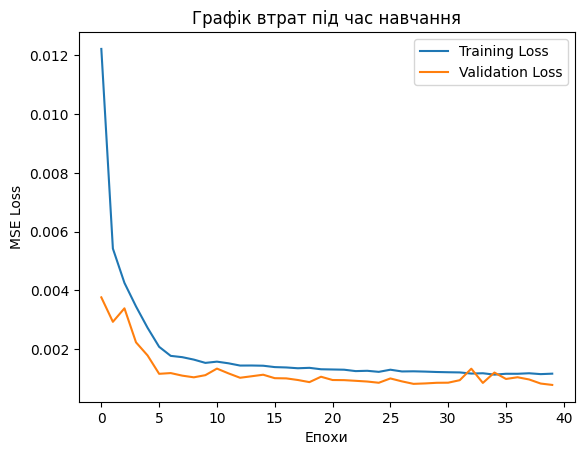

In [161]:
# Побудова графіку втрат (loss) під час навчання
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Епохи')
plt.ylabel('MSE Loss')
plt.title('Графік втрат під час навчання')
plt.show()

In [162]:
# Прогнозування температури
predicted_temp = model.predict(X_test)
predicted_temp = scaler.inverse_transform(predicted_temp)
actual_temp = scaler.inverse_transform(y_test.reshape(-1, 1))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


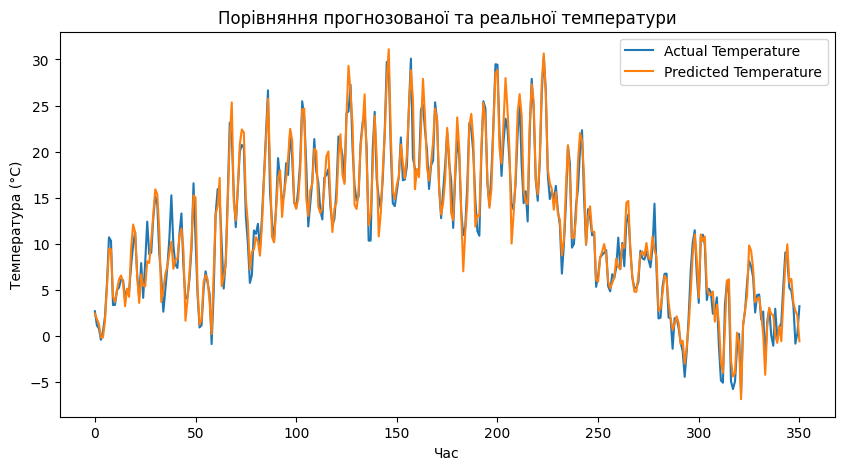

In [163]:
# Побудова графіку для порівняння прогнозу та реальних значень
plt.figure(figsize=(10, 5))
# Зменшення кількості точок для відображення на графіку для уникнення щільного малюнку
plt.plot(actual_temp[::5], label='Actual Temperature')
plt.plot(predicted_temp[::5], label='Predicted Temperature')
plt.xlabel('Час')
plt.ylabel('Температура (°C)')
plt.title('Порівняння прогнозованої та реальної температури')
plt.legend()
plt.show()
